# Retrieval Dataset Analysis Report

## 1. Methodology: Causal Relevance Verification

This report analyzes the empirical relevance of documentation for solving software engineering tasks. Instead of relying on static similarity (embeddings) or human labeling, we use **Monte Carlo Causal Inference**.

### The Algorithm
For each query $q$ and a pool of candidate documents $C(q)$:
1.  **Randomized Trials:** We execute $N$ trials. In each trial, a random subset $S \subset C(q)$ is injected into the LLM's context window.
2.  **Blind Solving:** The LLM attempts to solve the task using *only* $S$.
3.  **Impact Scoring (Delta P):** We calculate the marginal contribution of each document $d$:
    $$ \Delta P(d) = P(\text{Success} | d \in S) - P(\text{Success} | d \notin S) $$
### Interpretation
*   **$\Delta P \approx 1.0$**: **Critical**. The task cannot be solved without this document.
*   **$\Delta P > 0.1$**: **Helpful**. The document improves success rate but might be redundant with others.
*   **$\Delta P \approx 0.0$**: **Irrelevant**. The document is noise.
*   **$\Delta P < -0.1$**: **Toxic**. The document actively misleads the model (e.g., hallucination trigger).

In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import os
import json
from pathlib import Path

print(f"Current Working Directory: {os.getcwd()}")
# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Current Working Directory: /Users/ivanmkc/Documents/code/agent-generator


In [2]:
# Load Latest Run Logs (YAML Stream)
log_files = glob.glob("../logs/*.yaml")
if not log_files:
    # Try relative to root if running from there
    log_files = glob.glob("logs/*.yaml")

if not log_files:
    print("No log files found.")
else:
    latest_log = max(log_files, key=os.path.getctime)
    print(f"Loading logs from: {latest_log}")
    
    trial_events = []
    with open(latest_log, 'r') as f:
        events = list(yaml.safe_load_all(f))
        for event in events:
            if event and event.get('event') == 'trial_complete':
                trial_events.append(event)
    
    trials_df = pd.DataFrame(trial_events)
    print(f"Loaded {len(trials_df)} trials.")

No log files found.


## 2. Impact Score Distribution (Signal vs. Noise)

This Kernel Density Estimate (KDE) plot visualizes the distribution of utility across different candidate sources.

**How to read this graph:**
*   **X-Axis (Delta P):** Impact Score. Right is good, Left is bad.
*   **Peaks:**
    *   A sharp peak at **0.0** means most documents are noise (expected for Random/Vector search).
    *   A "shoulder" or secondary peak to the **right (> 0.2)** represents the **Signal** (useful documents).
    *   Mass to the **left (< 0.0)** indicates **Distractors** that confuse the model.
*   **Goal:** We want the `retrieved` and `gold_mined` distributions to have heavy right tails.

Loading metadata from: retrieval_dataset_verified.yaml


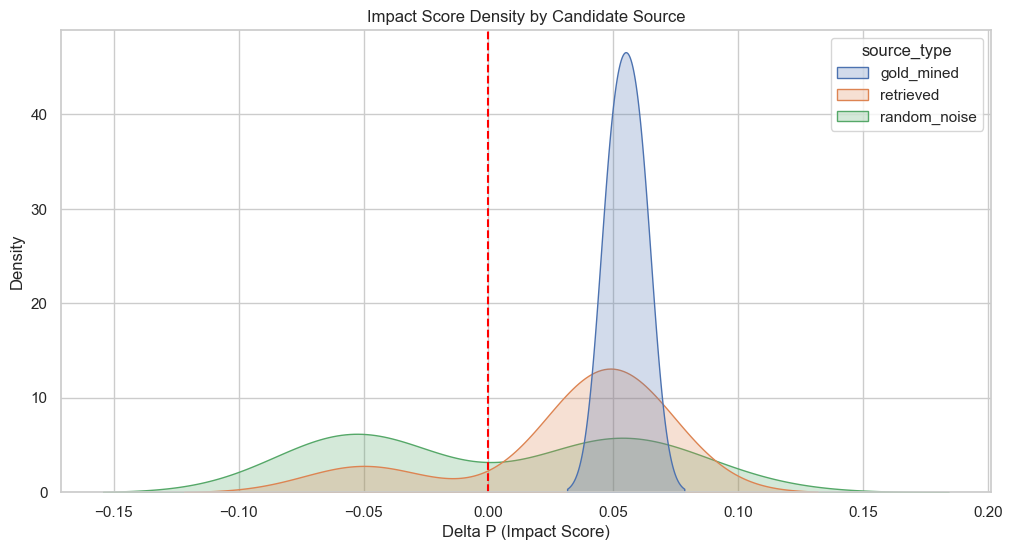

In [3]:
# Load Dataset Metadata
convergence_traces = []
records = []

dataset_path = Path("../retrieval_dataset_verified.yaml")
if not dataset_path.exists():
    dataset_path = Path("retrieval_dataset_verified.yaml")

if dataset_path.exists():
    print(f"Loading metadata from: {dataset_path}")
    with open(dataset_path, 'r') as f:
        data = yaml.safe_load(f)
    
    cases = data.get('cases', [])
    for case in cases:
        if 'convergence_trace' in case.get('metadata', {}):
            convergence_traces.append({
                'case_id': case['id'],
                'trace': case['metadata']['convergence_trace']
            })
            
        candidates = case.get('candidates', [])
        for ctx in candidates:
            meta = ctx.get('metadata', { })
            records.append({
                'case_id': case['id'],
                'fqn': ctx['fqn'],
                'source_type': ctx['type'],
                'delta_p': meta.get('delta_p', 0.0),
                'n_in': meta.get('n_in', 0),
            })
    stats_df = pd.DataFrame(records)

    if not stats_df.empty:
        plt.figure(figsize=(12, 6))
        sns.kdeplot(data=stats_df, x='delta_p', hue='source_type', fill=True, common_norm=False)
        plt.title('Impact Score Density by Candidate Source')
        plt.xlabel('Delta P (Impact Score)')
        plt.axvline(0, color='red', linestyle='--')
        plt.show()
else:
    print("Dataset file not found.")

## 3. Convergence Analysis (Statistical Confidence)

This plot tracks how our confidence in the impact scores evolves as we run more trials.

**How to read this graph:**
*   **Y-Axis (Max Standard Error):** Represents the uncertainty of our *least certain* estimate for a given case. 
*   **X-Axis (Trial Number):** Time.
*   **Trend:** Lines should slope downwards as $1/\sqrt{N}$.
*   **Threshold:** The red line (0.1) is our target. Once a line crosses below this, we stop testing that case.
*   **Interpretation:** Lines that flatten out above the red line indicate "Hard" or "Noisy" cases where the model's performance is highly erratic, requiring more samples.

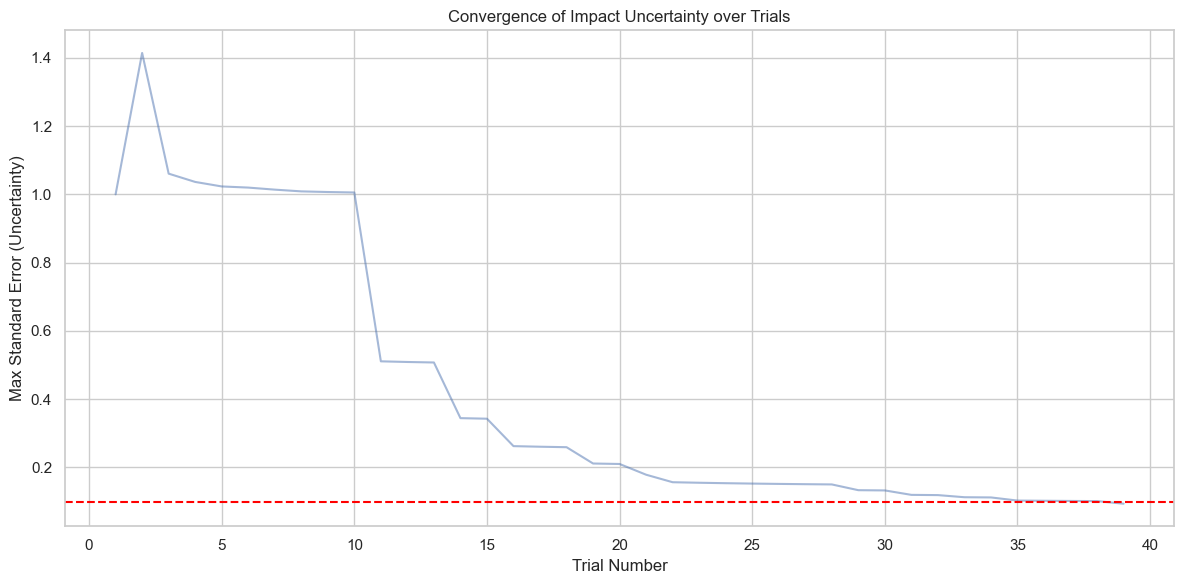

In [4]:
# Convergence Analysis
if convergence_traces:
    plt.figure(figsize=(12, 6))
    for trace in convergence_traces:
        y = trace['trace']
        x = range(1, len(y) + 1)
        plt.plot(x, y, alpha=0.5, label=trace['case_id'][:20])

    plt.title('Convergence of Impact Uncertainty over Trials')
    plt.xlabel('Trial Number')
    plt.ylabel('Max Standard Error (Uncertainty)')
    plt.axhline(0.1, color='red', linestyle='--', label='Convergence Threshold (0.1)')
    plt.tight_layout()
    plt.show()

## 4. Trial Dynamics (Success Rate)

**How to read this graph:**
*   Each line tracks the **Cumulative Mean Success Rate** for a specific query.
*   **Stable High Lines:** Easy queries. The model knows the answer or context is consistently relevant.
*   **Stable Low Lines:** Impossible queries. Even with context, the model fails.
*   **Fluctuating Lines:** Sensitive queries. Success depends heavily on which specific subset of documents was included in that trial.

In [5]:
# Trial Dynamics
if 'trials_df' in locals() and not trials_df.empty:
    trials_df['success'] = trials_df['is_correct'].astype(int)
    trials_df['cumulative_success_rate'] = trials_df.groupby('case_id')['success'].expanding().mean().reset_index(level=0, drop=True)
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=trials_df, x='trial_index', y='cumulative_success_rate', hue='case_id', alpha=0.7)
    plt.title('Cumulative Success Rate by Case')
    plt.xlabel('Trial Index')
    plt.ylabel('Success Rate')
    plt.show()

## 5. Potential Additional Analyses (Future Work)

To deeper understand the dataset quality, we recommend adding the following analyses:

1.  **Hardest Queries:** Identify queries with $\text{Max}(\Delta P) \approx 0$, indicating that *none* of the retrieved documents helped (Retrieval Gap).
2.  **Toxic Document Detection:** List documents with statistically significant negative $\Delta P$. These should be audited for outdated info.
3.  **Retriever Efficiency:** Compare the Recall@K of the initial `EmbeddingRetriever` vs. the `GoldMiner` to quantify the "Semantic Gap".
4.  **Set Sufficiency:** Analyze cases where $P(\text{Success}) > 0$ but $\text{Max}(\Delta P) < 0.5$, suggesting that success requires a *combination* of documents (feature interaction) rather than a single key.